In [3]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

symbol = 'QQQ'
files = sorted(os.listdir(f'data/{symbol}'), key=lambda f: f'{f:>7}')


In [4]:
results = []
leverage = {}
for f in files:
    df = pd.read_csv(f'data/{symbol}/{f}')
    df.start_date = pd.to_datetime(df.start_date)
    df.end_date = pd.to_datetime(df.end_date)
    df['TTL'] = ((df.end_date - df.start_date).dt.days / 7).round(0)
    call_profits = df.call_end_price / df.call_start_price - 1
    mean_call_profit = call_profits.mean()
    annual_call_profit = (call_profits / df.TTL * 52).mean()
    positive_ratio = (call_profits > 0).mean()
    call_leverage = (df.call_strike_price / df.call_start_price).median()
    print(f'[{f:>7}] '
          f'mean profit: {mean_call_profit:+5.0%} '
          f'annual profit: {annual_call_profit:+6.0%} '
          f'positive: {positive_ratio:5.0%} '
          f'leverage: {call_leverage:4.1f} '
        #   f'daily tx: {df.call_daily_tx.median():4.0f} '
          f'transactions: {len(df):3d} ')
    results.append({
        'profit': mean_call_profit,
        'positive': positive_ratio,
    })

    w = int(re.match(r'\d+', f)[0])
    leverage[w] = call_leverage    

[ 1w.csv] mean profit:  +20% annual profit: +1066% positive:   43% leverage: 92.1 transactions: 103 
[ 2w.csv] mean profit:  +20% annual profit:  +510% positive:   43% leverage: 60.7 transactions: 102 
[ 3w.csv] mean profit:  +26% annual profit:  +451% positive:   45% leverage: 47.4 transactions: 101 
[ 4w.csv] mean profit:  +29% annual profit:  +372% positive:   44% leverage: 40.0 transactions:  99 
[ 5w.csv] mean profit:  +26% annual profit:  +274% positive:   44% leverage: 35.8 transactions:  97 
[ 6w.csv] mean profit:  +27% annual profit:  +238% positive:   50% leverage: 31.5 transactions:  94 
[ 7w.csv] mean profit:  +43% annual profit:  +322% positive:   54% leverage: 28.5 transactions:  56 
[ 8w.csv] mean profit:  +15% annual profit:   +98% positive:   44% leverage: 25.7 transactions:  27 
[ 9w.csv] mean profit:  +37% annual profit:  +214% positive:   56% leverage: 25.0 transactions:  27 
[10w.csv] mean profit:  +40% annual profit:  +209% positive:   48% leverage: 23.4 transacti

In [5]:
leverage

{1: 92.0844327176781,
 2: 60.71839464882943,
 3: 47.354138398914515,
 4: 40.0,
 5: 35.7926221335992,
 6: 31.53118919836513,
 7: 28.45482587416874,
 8: 25.657298277425205,
 9: 24.981949458483754,
 10: 23.388429752066116,
 11: 22.802813653136532,
 12: 20.210280373831775,
 13: 20.966962090351938,
 14: 19.204628599977436,
 15: 18.361581920903955,
 16: 18.489638521389,
 17: 16.84843687457022,
 18: 16.657967988865693,
 19: 16.006021073758152,
 20: 15.980370425102212,
 21: 15.018484288354898,
 22: 14.927012321632724,
 23: 14.291474654377879,
 24: 13.770913770913772,
 25: 13.528843202327359,
 26: 13.204442616207324}

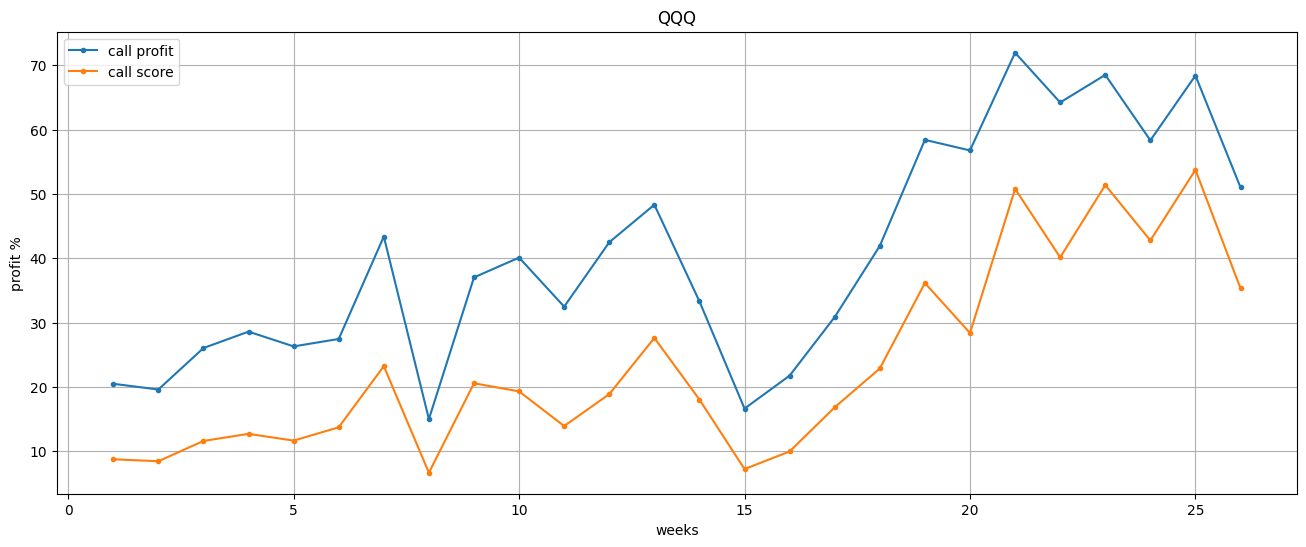

In [6]:
plt.figure(figsize=(16,6))
plt.plot([None]+[r['profit'] * 100 for r in results], label='call profit', marker='.')
plt.plot([None]+[r['profit'] * r['positive'] * 100 for r in results], label='call score', marker='.')
plt.legend(loc='best')
plt.title(symbol)
plt.xlabel('weeks')
plt.ylabel('profit %')
plt.grid()
plt.show()

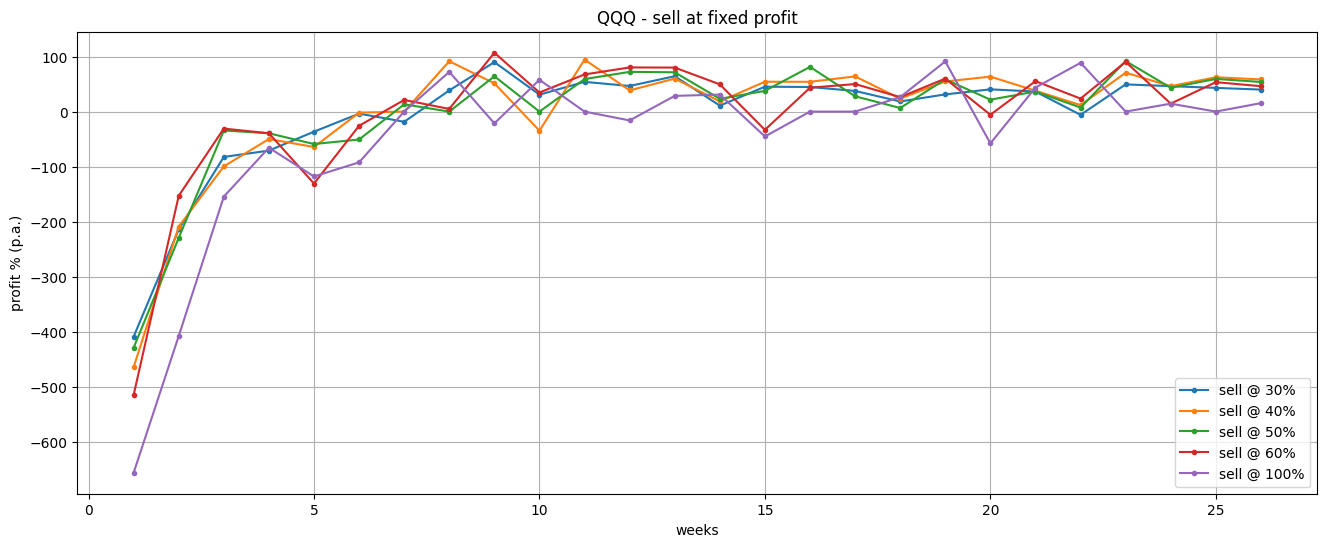

In [7]:
profit_thresholds = [0.3,0.4,0.5,0.6,1]
results = []
for f in files:
    df = pd.read_csv(f'data/{symbol}/{f}')
    df.start_date = pd.to_datetime(df.start_date)
    df.end_date = pd.to_datetime(df.end_date)
    df['TTL'] = ((df.end_date - df.start_date).dt.days / 7).round(0)
    call_max_profits = df.call_max_price / df.call_start_price - 1
    weeks = df.TTL.median()
    r = {}
    for p in profit_thresholds:
        q = (call_max_profits >= p).mean()
        r[p] = (q * (p + 1) - 1) * 52 / weeks
    results.append(r)

plt.figure(figsize=(16,6))

for p in profit_thresholds:
    plt.plot([None]+[r[p] * 100 for r in results], label=f'sell @ {p:.0%}', marker='.')

plt.legend(loc='best')
plt.title(symbol + ' - sell at fixed profit')
plt.xlabel('weeks')
plt.ylabel('profit % (p.a.)')
plt.grid()
plt.show()

In [8]:
df = pd.read_csv(f'data/{symbol}/1w.csv')
df.start_date = pd.to_datetime(df.start_date)
df = df.set_index('start_date')
df['call_max_profit'] = df.call_max_price / df.call_start_price - 1
for p in [0.45,0.5,0.55,1]:
    q = (df['call_max_profit'] >= p).mean()
    profit = q * (p + 1) - 1
    print(f'sell @ {p:4.0%}: success rate {q:.0%} = profit: {profit:3.0%} ({profit*52:5.0%} p.a.)')

sell @  45%: success rate 63% = profit: -8% (-442% p.a.)
sell @  50%: success rate 61% = profit: -8% (-429% p.a.)
sell @  55%: success rate 58% = profit: -10% (-505% p.a.)
sell @ 100%: success rate 44% = profit: -13% (-656% p.a.)


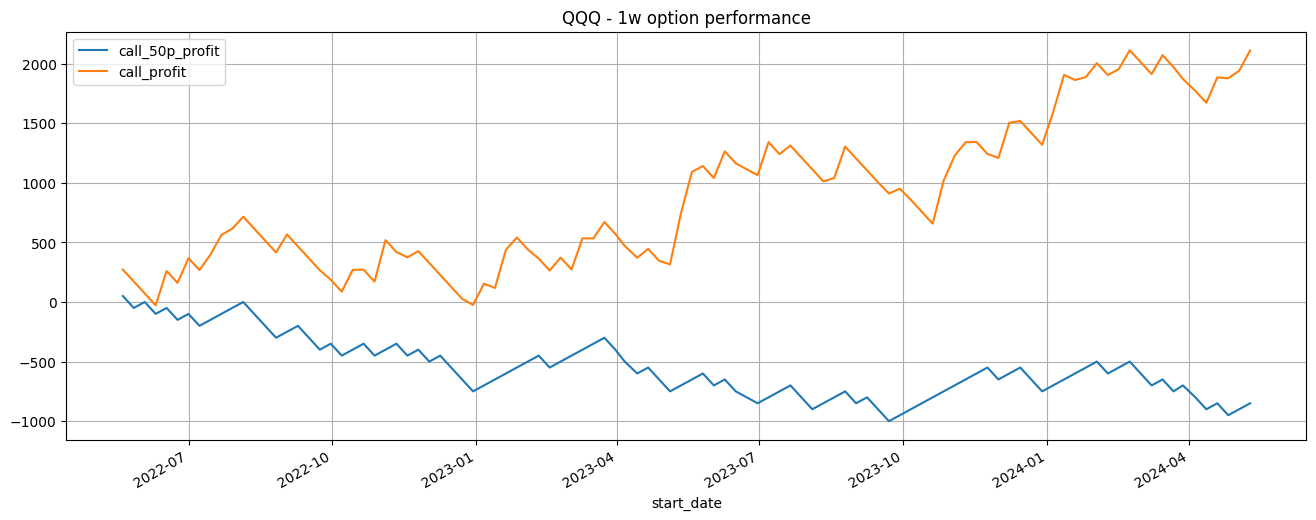

In [9]:

plt.figure(figsize=(16,6))
plt.title(symbol + ' - 1w option performance')

df['call_50p_profit'] = df.call_max_profit.apply(lambda x: 50 if x >= 0.5 else -100)
df.call_50p_profit.cumsum().plot()

df['call_profit'] = (df.call_end_price / df.call_start_price - 1) * 100
df.call_profit.cumsum().plot()

plt.legend(loc='best')
plt.grid()


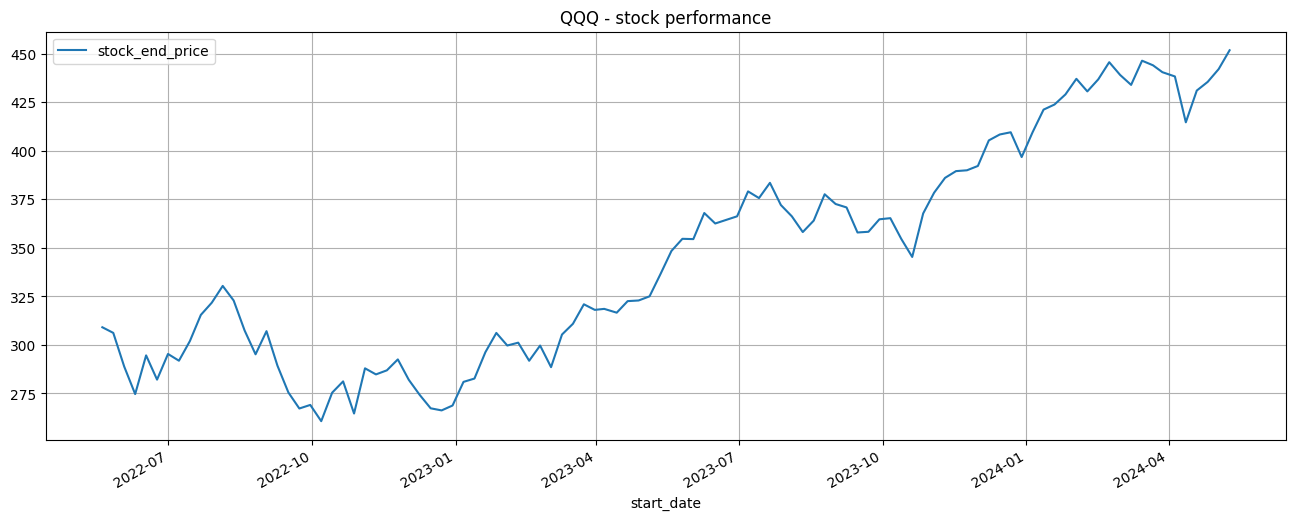

In [10]:
plt.figure(figsize=(16,6))
plt.title(symbol + ' - stock performance')
df.stock_end_price.plot()
plt.legend(loc='best')
plt.grid()